## From clean_data to first dataset

In [1]:
# modules
import pickle
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd

from datetime import datetime

In [2]:
loc_clean_data = '../data/clean_data/'

### Show calculations on data for one day

In [3]:
with open(loc_clean_data + 'clean_dates.txt', 'rb') as f:
    dates = pickle.load(f)

date = dates.date

start_date = datetime.strptime('10-12-2020', '%d-%m-%Y')
end_date = datetime.strptime('11-12-2020', '%d-%m-%Y')
idx = (start_date < date)  & (date < end_date) 

dates = dates[idx]
dates

,file_name,date
0,../data/clean_data/image_20201210-00h0457.nc,2020-12-10 00:04:57.823948032
1,../data/clean_data/image_20201210-00h1457.nc,2020-12-10 00:14:57.818392960
2,../data/clean_data/image_20201210-00h2457.nc,2020-12-10 00:24:57.820765952
3,../data/clean_data/image_20201210-00h3457.nc,2020-12-10 00:34:57.816974976
4,../data/clean_data/image_20201210-00h4457.nc,2020-12-10 00:44:57.811352064
...,...,...
138,../data/clean_data/image_20201210-23h0457.nc,2020-12-10 23:04:57.601401984
139,../data/clean_data/image_20201210-23h1457.nc,2020-12-10 23:14:57.601948032
140,../data/clean_data/image_20201210-23h3457.nc,2020-12-10 23:34:57.595847936
141,../data/clean_data/image_20201210-23h4457.nc,2020-12-10 23:44:57.592283008


## combine files of one day in one xarray.

In [89]:
file = dates.file_name.loc[0]
ds = xr.open_dataset(file)
ds

# Only keep points which are in the right area and do contain a wind speed
dss = []
for file in dates.file_name:
    ds = xr.open_dataset(file)
    dss.append(ds)

ds = xr.concat([dss[3], dss[0], dss[1]], 't')

invalid =np.sum(ds.ct == 0, axis = (1,2))
# ds = ds.where(invalid < 10000, drop = True)

ds

<xarray.Dataset>
Dimensions:  (t: 3, x: 441, y: 443)
Coordinates:
  * x        (x) float64 1.1e+06 1.095e+06 1.09e+06 ... -1.104e+06 -1.109e+06
  * y        (y) float64 1.113e+06 1.108e+06 1.103e+06 ... -1.102e+06 -1.107e+06
  * t        (t) datetime64[ns] 2020-12-10T00:34:57.816974976 ... 2020-12-10T...
Data variables:
    cth      (t, x, y) float32 8.658e+03 9.394e+03 9.394e+03 ... nan nan nan
    cod      (t, x, y) float32 0.4859 0.7545 0.774 0.4688 ... nan nan nan nan
    ct       (t, x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    u        (t, x, y) float32 -13.24 -13.24 -13.24 -13.24 ... nan nan nan nan
    v        (t, x, y) float32 -9.394 -9.394 -9.394 -9.394 ... nan nan nan nan
Attributes:
    extent:   [-50. -30.  -5.  15.]

In [91]:
ds.t
# dss[0:2]

<xarray.DataArray 't' (t: 3)>
array(['2020-12-10T00:34:57.816974976', '2020-12-10T00:04:57.823948032',
       '2020-12-10T00:14:57.818392960'], dtype='datetime64[ns]')
Coordinates:
  * t        (t) datetime64[ns] 2020-12-10T00:34:57.816974976 ... 2020-12-10T...

## determine starting pixels

In [6]:
dx = 50
dy = 50
i_indx = np.arange(int(dx/2), ds.dims['x'], dx)
j_indx = np.arange(int(dy/2), ds.dims['y'], dy)

i, j = [grid.flatten() for grid in np.meshgrid(i_indx, j_indx)]
i_start, j_start =  [grid.flatten() for grid in np.meshgrid(i_indx, j_indx)]

# check if pixel is in the domain
pixels = []
var = ['u', 'v']
for p in range(len(i)):
    check = np.sum([ds.isel(x = i[p], y= j[p], t = 0)[v] for v in var])
    if np.isnan(check):
#         print(ds.isel(x = i[p], y= j[p], t = 0))
        continue
    else:
        pixels.append(p)
print('p =  ', pixels)
i, j = i[pixels], j[pixels]
i_start, j_start = np.copy(i),np.copy(j)

# make n_t x n_p - matrix (n_t number of timesteps, n_p number of pixels) with x-
# and y-  coordinates and indexes. 
n_t, n_p = ds.t.size, len(i)
xloc = np.empty((n_t, n_p))
yloc = np.empty((n_t, n_p))
xloc[:] = np.nan
yloc[:] = np.nan
xloc[0, :] = i
yloc[0, :] = j


p =   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 72]


In [7]:
var = list(ds.data_vars)
np.sum([ds.isel(x = 400, y= 400, t = 0)[v] for v in var])

nan

In [8]:
def nextLoc(ds, k, i, j
           ):
    """
    Function which determines the next location for a pixel at (k, i, j)
    t[k], x[i], y[j]
    returns new indices
    """
    
    t1 = ds.t[k] 
    x = ds.x[i]
    y = ds.y[j]

    dt = ds.t[k+1] - t1

    dt = (ds.t[k+1].data - t1.data ) 
    if np.isnan(ds.u[k,i,j].data):
        raise ValueError
    dx = ds.u[k,i,j].data * dt / np.timedelta64(1, 's') # m
    dy = ds.v[k,i,j].data * dt / np.timedelta64(1, 's') # m
    x_new = x + dx
    y_new = y + dy

    # First, find the index of the grid point nearest a specific lat/lon.   
    absx = np.abs(ds.x-x_new)
    absy = np.abs(ds.y-y_new)
    c = np.maximum(absx, absy)

    ([xloc], [yloc]) = np.where(c == np.min(c))

    
    return  xloc, yloc

## Determine Pixel path

In [9]:

for p in range(n_p):
    for k in range(0, n_t-1):
#         print(k ,i[p], j[p], p , '           ', end = '\r')
        try:
            i[p], j[p] = nextLoc(ds, k, i[p], j[p])
        except ValueError:
            break
        xloc[k+1, p] = i[p]
        yloc[k+1, p] = j[p]
    print(f'pixel {p:3.0f} of {n_p}', end = '\r')


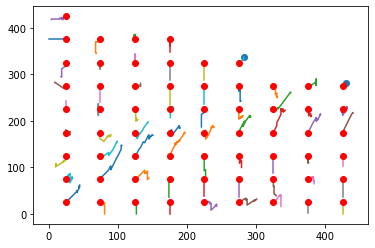

In [10]:
# plt.figure(figsize = (20,20))
for p in range(n_p):
    plt.plot(xloc.T[p], yloc.T[p])
    plt.plot(xloc.T[p][0], yloc.T[p][0], 'ro')
plt.scatter([430, 282], [282, 337])
plt.show()
            

## Make dataframe

In [11]:

n_nanrows = 1 # number of nan rows between different pixel paths. 

# determine values of all pixels paths
X = np.zeros(((n_t + n_nanrows) * n_p , 3))
for p in range(n_p):
    for i in range(n_t + n_nanrows ):
#     print(i, xloc[i,p], yloc[i,p])

        if i < n_t:
#             X[(ds.t.size + hoi) * p + i, 2] = p
            if np.isnan(xloc[i, p]):
                X[(n_t + n_nanrows) * p + i, 2] = -10
            else:
                X[(n_t + n_nanrows) * p + i, 0] = ds.cth[i, int(xloc[i, p]), int(yloc[i,p]) ]
                X[(n_t + n_nanrows) * p + i, 1] = ds.cod[i, int(xloc[i, p]), int(yloc[i,p]) ]
                X[(n_t + n_nanrows) * p + i, 2] = ds.ct[i, int(xloc[i, p]), int(yloc[i,p]) ]
        else: 
            X[(n_t + n_nanrows) * p + i, :] = np.nan # add a nan row to seperate different days/pixels


df = pd.DataFrame(X,
                   columns=['h_t', 'd_t', 'ct']
                 )

df = df.drop(df[df.ct == -10].index) # drop rows for pixels that went out of the frame

# add column with cloud/clear sky/not defined
df['cloud'] = (
    np.select(
        condlist=[df.ct > 1, df.ct == 1], 
        choicelist=['cloud', 'clear sky'], 
        default=np.nan))

# clear clouds with insuficient data
df.loc[(df.cloud == 'cloud') & df.h_t.isna(), ['d_t' , 'cloud']] = np.nan
df.loc[(df.cloud == 'cloud') & df.d_t.isna(), ['h_t' , 'cloud']] = np.nan

# clear data of clear sky
df.loc[df.cloud == 'clear sky',['h_t', 'd_t']] = np.nan

df.d_t = np.log(df.d_t) #-> should add this in the data processing ?

# combine current state and next state in one row
s_t = df.iloc[:-1].reset_index(drop = True)
s_t1 = df.iloc[1:].reset_index(drop = True).add_suffix('_next')
df = pd.concat([s_t, s_t1], axis = 1)
print(df.columns)



Index(['h_t', 'd_t', 'ct', 'cloud', 'h_t_next', 'd_t_next', 'ct_next',
       'cloud_next'],
      dtype='object')


,h_t,d_t,ct,cloud,h_t_next,d_t_next,ct_next,cloud_next
0,2996.489990,1.652537,6.0,cloud,4983.366211,1.472084,6.0,cloud
1,4983.366211,1.472084,6.0,cloud,433.389252,3.092443,5.0,cloud
2,433.389252,3.092443,5.0,cloud,580.802673,2.422194,5.0,cloud
3,580.802673,2.422194,5.0,cloud,7950.556641,0.411399,3.0,cloud
4,7950.556641,0.411399,3.0,cloud,11316.648438,1.194251,4.0,cloud
...,...,...,...,...,...,...,...,...
2466,NaN,NaN,1.0,clear sky,420.875916,-0.171545,2.0,cloud
2467,420.875916,-0.171545,2.0,cloud,808.179443,0.633895,2.0,cloud
2468,808.179443,0.633895,2.0,cloud,907.675842,1.092336,2.0,cloud
2469,907.675842,1.092336,2.0,cloud,1166.793823,1.894767,5.0,cloud


In [58]:
def saveModelData(df, output_loc, date):
    d = date.strftime('%Y%m%d') # maybe change day/month to julian days
    file_name = f'{output_loc}/data_{d}.csv'
    df.to_csv(file_name)
    return file_name
     
# path = '../data/clean_data/' + filename
# df.to_csv(path)
saveModelData(df, '../data/model1_data/', start_date)

'../data/model1_data//data_20201210.csv'

## combine df's from different days.


In [72]:
import os
loc_model1_data = '../data/model1_data/'
files = [loc_model1_data + f for f in os.listdir(loc_model1_data) if (os.path.isfile(os.path.join(loc_model1_data, f)))]
files

dfs =[]
for file in files:
    df = pd.read_csv(file)   
    print(len(df))
    dfs.append(df)
df = pd.concat(dfs)
df

7149
194


,Unnamed: 0,h_t,d_t,ct,cloud,h_t_next,d_t_next,ct_next,cloud_next
0,0,9667.022461,0.645486,0.0,NaN,8914.695312,-0.542819,0.0,NaN
1,1,8914.695312,-0.542819,0.0,NaN,11397.832031,-0.800154,0.0,NaN
2,2,11397.832031,-0.800154,0.0,NaN,11124.064453,-1.795582,0.0,NaN
3,3,11124.064453,-1.795582,0.0,NaN,11599.266602,-0.093511,0.0,NaN
4,4,11599.266602,-0.093511,0.0,NaN,11775.674805,-0.658503,0.0,NaN
...,...,...,...,...,...,...,...,...,...
189,189,1329.162109,0.062553,2.0,cloud,NaN,NaN,NaN,NaN
190,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,191,NaN,NaN,NaN,NaN,48.832592,0.591561,2.0,cloud
192,192,48.832592,0.591561,2.0,cloud,NaN,NaN,1.0,clear sky


In [73]:
# available transitions
pd.crosstab(df['cloud'], df['cloud_next'])

cloud_next,clear sky,cloud
cloud,,
clear sky,616,112
cloud,114,1285


## cloud to cloud

In [14]:
df_cc = df.loc[(df.cloud == 'cloud') & (df.cloud_next == 'cloud') ]
df_cc.insert(len(df_cc.columns), 'dh', df_cc.apply(lambda row: row.h_t_next - row.h_t, axis = 1))
df_cc.insert(len(df_cc.columns), 'dd', df_cc.apply(lambda row: row.d_t_next - row.d_t, axis = 1))
df_cc.head()

,h_t,d_t,ct,cloud,h_t_next,d_t_next,ct_next,cloud_next,dh,dd
0,2996.489990,1.652537,6.0,cloud,4983.366211,1.472084,6.0,cloud,1986.876221,-0.180452
1,4983.366211,1.472084,6.0,cloud,433.389252,3.092443,5.0,cloud,-4549.976959,1.620358
2,433.389252,3.092443,5.0,cloud,580.802673,2.422194,5.0,cloud,147.413422,-0.670248
3,580.802673,2.422194,5.0,cloud,7950.556641,0.411399,3.0,cloud,7369.753967,-2.010795
4,7950.556641,0.411399,3.0,cloud,11316.648438,1.194251,4.0,cloud,3366.091797,0.782852


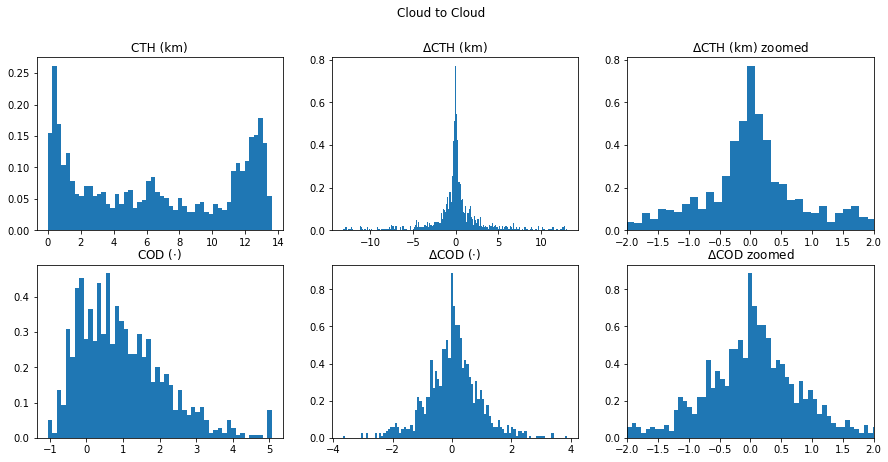

In [74]:
fig, ax = plt.subplots(2,3,figsize = (15, 7))
# cth
ax[0,0].hist(df_cc.h_t * 1e-3, bins = 50, density = True)
ax[0,0].set_title('CTH (km)')
ax[0,1].hist(df_cc.dh * 1e-3, bins = 200, density = True)
ax[0,1].set_title('$\Delta$CTH (km)')
ax[0,2].hist(df_cc.dh * 1e-3, bins = 200, density = True)
ax[0,2].set_title('$\Delta$CTH (km) zoomed')
ax[0,2].set(xlim = [-2, 2])
ax[1,0].hist(df_cc.d_t, bins = 50, density = True)
ax[1,0].set_title('COD ($\cdot$)')
ax[1,1].hist(df_cc.dd, bins = 100, density = True)
ax[1,1].set_title('$\Delta$COD ($\cdot$)')
ax[1,2].hist(df_cc.dd, bins = 100, density = True)
ax[1,2].set_title('$\Delta$COD zoomed')
ax[1,2].set(xlim = [-2, 2])
fig.suptitle('Cloud to Cloud')
plt.show()


In [16]:
df_cc[['dh', 'dd']].cov()

# df_cc.dh.std()

,dh,dd
dh,1.115269e+07,6.590816
dd,6.590816e+00,0.799327


-> what would be a suitable fit for $\Delta$h and $\Delta$d

In [95]:
mu_h = [6e3, 12e3] #
mu_d = [0, 2]

mu_h, mu_d = np.meshgrid(mu_h, mu_d)
mu_h, mu_d = [x.flatten() for x in [mu_h, mu_d]]

delta_h = 300 #m
delta_d = .1

bins = [[[h - delta_h, h + delta_h], [d - delta_d, d + delta_d]] for h,d in zip(mu_h, mu_d)]
print(bins)

[[[5700.0, 6300.0], [-0.1, 0.1]], [[11700.0, 12300.0], [-0.1, 0.1]], [[5700.0, 6300.0], [1.9, 2.1]], [[11700.0, 12300.0], [1.9, 2.1]]]


[[[5700.0, 6300.0], [-0.1, 0.1]], [[11700.0, 12300.0], [1.9, 2.1]]]


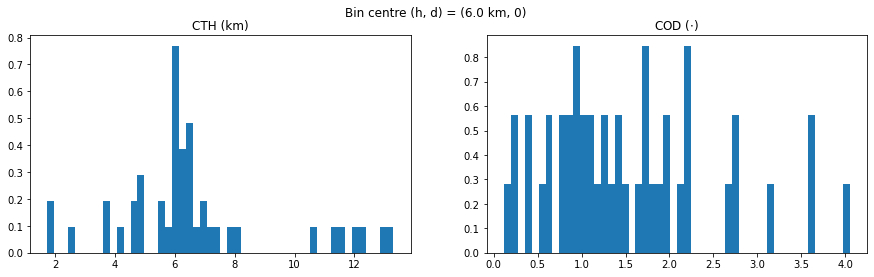

In [47]:
b = bins[0]

# filter cloud to cloud on from within bin
# for h
df_temp = df_cc.loc[(df_cc.h_t > b[0][0]) & (df_cc.h_t < b[0][1])]

def plot_distribution_next_cloud(df, title = None, **kwargs):
    fig, ax = plt.subplots(1,2,figsize = (15, 4))
    # cth
    ax[0].hist(df.h_t_next * 1e-3, bins = 50, **kwargs)
    ax[0].set_title('CTH (km)')
    # cod
    ax[1].hist(df.d_t_next, bins = 50, **kwargs)
    ax[1].set_title('COD ($\cdot$)')
    if title != None:
        fig.suptitle(title)
    return fig

title = f'Bin centre (h, d) = ({mu_h[0]*1e-3} km, {mu_d[0]})'
fig = plot_distribution_next_cloud(df_temp, title = title, density = True)
fig.savefig('distribution.png')

### clear sky to cloud

number of clear sky to cloud transitions =  147


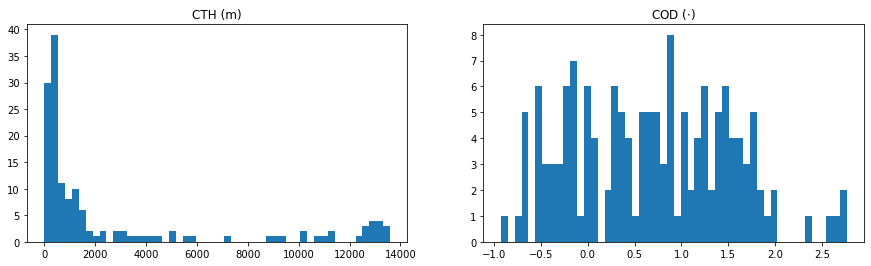

In [17]:
df_sc = df.loc[(df.cloud == 'clear sky') & (df.cloud_next == 'cloud') ]
print('number of clear sky to cloud transitions = ', len(df_sc))
fig, ax = plt.subplots(1,2,figsize = (15, 4))
# cth
ax[0].hist(df_sc.h_t_next, bins = 50)
ax[0].set_title('CTH (m)')
# cod
ax[1].hist(df_sc.d_t_next, bins = 50)
ax[1].set_title('COD ($\cdot$)')
plt.show()

### to clear sky

number of to clear sky transitions =  857


,n_total,n_to_clear_sky,p_i
ct,,,
0.0,15,0.0,0.000000
1.0,920,702.0,0.763043
2.0,293,65.0,0.221843
3.0,205,16.0,0.078049
4.0,406,27.0,0.066502
5.0,140,35.0,0.250000
6.0,180,3.0,0.016667
7.0,85,8.0,0.094118
8.0,6,0.0,0.000000


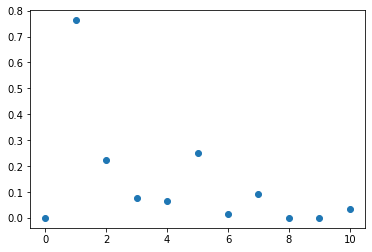

In [18]:
df_s = df.loc[((df.cloud == 'clear sky') | (df.cloud == 'cloud')) & (df.cloud_next == 'clear sky')  ]
df_s
print('number of to clear sky transitions = ', len(df_s))
clear_sky = df.groupby('ct').count().rename(columns = {'cloud': 'n_total'})
clear_sky['n_to_clear_sky'] = df_s.groupby('ct').count().cloud
clear_sky = clear_sky[['n_total', 'n_to_clear_sky']].fillna(0)
clear_sky['p_i'] = clear_sky.apply(lambda row: row.n_to_clear_sky / row.n_total, axis = 1 )

plt.scatter(clear_sky.index,clear_sky.p_i)
clear_sky